# Maryam Hosseinali - 610398209 - HW2 - IR

Part 1

In [ ]:
import os
import string
import re


def read_text_files(directory):
    documents = []
    for filename in os.listdir(directory):
        if filename.endswith('.txt'):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding='utf-8') as file:
                # Read file contents and split into terms
                terms = file.read().split()
                documents.append(terms)
    return documents


def preprocess_documents(documents):
    def clean_term(term):
        # Convert to lowercase and remove all punctuation
        return re.sub(r'[^\w\s]', '', term.lower())

    preprocessed_docs = []
    for doc in documents:
        # Clean each term, remove empty strings, create unique sorted list
        cleaned_terms = [clean_term(term) for term in doc if clean_term(term)]
        unique_terms = sorted(set(cleaned_terms))

        preprocessed_docs.append(unique_terms)

    return preprocessed_docs


# Specify the directory containing your text files
document_directory = './document'

# Read documents from the directory
raw_documents = read_text_files(document_directory)

# Preprocess the documents
processed_docs = preprocess_documents(raw_documents)



# **Document Reading and Preprocessing**



---

## **Steps**

### **1. Reading Documents**

### **2. Preprocessing Terms**
The `preprocess_documents` function processes the raw terms from the documents to standardize and clean data:
- **Lowercase Conversion:** All terms are converted to lowercase.
- **Punctuation Removal:** Non-alphanumeric characters are removed.
- **Sorting and Deduplication**

### **3. Integration**
- **Directory Specification:** The directory containing the text files is set as `document_directory`.
- **Execution:**
  1. Documents are read using `read_text_files`.
  2. The terms are preprocessed using `preprocess_documents`.

---


---

## **Output**
- **Raw Documents:** A list of documents, where each document contains raw, unprocessed terms.
- **Processed Documents:** A cleaned, deduplicated, and sorted list of unique terms for each document.


---


In [ ]:
def create_inverted_index(preprocessed_docs):

    # Create dictionary of unique terms across all documents
    dictionary = set()
    for doc in preprocessed_docs:
        dictionary.update(doc)

    # Sort dictionary alphabetically
    dictionary = sorted(dictionary)

    # Create postings lists
    postings_lists = {}
    for term in dictionary:
        # Find documents containing the term
        doc_ids = [
            doc_id + 1  # Document IDs start from 1
            for doc_id, doc in enumerate(preprocessed_docs)
            if term in doc
        ]
        postings_lists[term] = doc_ids

    return dictionary, postings_lists

# Create inverted index
dictionary, postings_lists = create_inverted_index(processed_docs)



# **Creating Inverted Index**

#
This section implements the inverted index. The inverted index maps terms from the dictionary to list of documents in which they appear, enabling efficient retrieval during search queries.

---

## **Steps**

### **1. Constructing the Dictionary**
The `create_inverted_index` function creates a global dictionary of unique terms across all documents:
- **Aggregation:** The terms from all preprocessed documents are combined into a single set to eliminate duplicates.
- **Sorting:** The terms are sorted alphabetically to facilitate efficient indexing and retrieval.

### **2. Generating Postings Lists**
For each term in the dictionary:
- A **postings list** is created, containing the IDs of documents where the term appears.
- Document IDs are represented as integers starting from 1.
- The postings lists ensure that the IDs are sorted in ascending order for consistency and efficiency.

### **3. Integration**
The function returns two key components:
1. **Dictionary:** A sorted list of unique terms across all documents.
2. **Postings Lists:** A mapping of each term to its corresponding sorted list of document IDs.


---

## **Output**
1. **Dictionary:** A sorted list of unique terms from all documents.
  
2. **Postings Lists:** A mapping of terms to the document IDs where they appear.
   

---



In [ ]:
def apply_front_coding(dictionary):
    if not dictionary:
        return []

    compressed_dict = []

    # Process terms in blocks of 4
    for i in range(0, len(dictionary), 4):
        # Take a block of 4 terms (or remaining terms if less than 4)
        block = dictionary[i:i+4]

        # First term of block is stored in full
        compressed_dict.append(block[0])

        # Process subsequent terms in the block
        for j in range(1, len(block)):
            # Find common prefix length with previous term
            prev_term = block[j-1]
            curr_term = block[j]

            # Calculate prefix length
            prefix_len = 0
            for k in range(min(len(prev_term), len(curr_term))):
                if prev_term[k] != curr_term[k]:
                    break
                prefix_len += 1

            # Store prefix length and unique suffix
            compressed_entry = (prefix_len, curr_term[prefix_len:])
            compressed_dict.append(compressed_entry)

    return compressed_dict

compressed_dict = apply_front_coding(dictionary)




# **Front-Coding Compression**


This section implements front-coding, a dictionary compression technique. The dictionary is divided into blocks, and terms within each block are partially stored based on their similarity to the previous term.

---

## **Steps**

### **1. Block Processing**
- The dictionary is divided into blocks of 4 terms. If fewer than 4 terms remain at the end, they form a smaller block.
- The first term in each block is stored in full to serve as a reference for subsequent terms.

### **2. Prefix Length Calculation**
- For each term in the block, except the first one:
  - The common prefix length between the term and the previous term is calculated.
  - Only the prefix length and the unique suffix of the term are stored.

### **3. Compressed Representation**
Each block stores:
- The first term in full.
- A tuple for subsequent terms, containing:
  - The prefix length.
  - The unique suffix of the term.


---

## **Output**
- **Compressed Dictionary:** A compact representation of the dictionary using front-coding.


---

## **Advantages of Front-Coding**
- **Space Efficiency:** By storing only the differences for most terms, front-coding significantly reduces the size of the dictionary.
- **Maintains Order:** The compressed representation preserves the alphabetical order of terms, which is crucial for efficient retrieval.



In [ ]:
import math

def delta_encode(postings_list):

    if not postings_list:
        return []

    # First convert to gaps/differences
    delta_list = [postings_list[0]]
    for i in range(1, len(postings_list)):
        delta_list.append(postings_list[i] - postings_list[i-1])

    return delta_list

def gamma_encode(number):

    if number <= 0:
        raise ValueError("Gamma encoding only works for positive integers")

    # Unary code for floor(log2(number)) + 1
    offset_len = math.floor(math.log2(number)) + 1
    unary_code = '1' * (offset_len - 1) + '0'

    # Binary representation of number without leading 1
    binary_offset = bin(number)[3:]
    binary_offset = binary_offset.zfill(offset_len - 1)

    return unary_code + binary_offset

def compress_postings_lists(postings_lists):

    compressed_postings = {}

    for term, doc_ids in postings_lists.items():
        # Delta encode first
        delta_list = delta_encode(doc_ids)

        # Gamma encode each delta
        gamma_encoded = [gamma_encode(num) for num in delta_list]

        compressed_postings[term] = gamma_encoded

    return compressed_postings


compressed_postings = compress_postings_lists(postings_lists)



# **Postings List Compression**


This section implements the compression of postings lists using two techniques:
1. **Delta Encoding** to store the differences  between consecutive document IDs.
2. **Gamma Encoding** to compress these gaps into a compact binary representation.


---

## **Steps**

### **1. Delta Encoding**
Delta encoding replaces the actual document IDs in a postings list with their gaps relative to the previous document ID:
- The first document ID remains unchanged.
- Each subsequent entry is replaced with the difference between the current document ID and the previous one.
- This step reduces redundancy when document IDs are close together.

---

### **2. Gamma Encoding**

1. Compute the **offset length** as `floor(log2(number)) + 1`.
2. Generate a **unary code** for the offset length minus 1.
3. Append the **binary representation of the number's offset**.


---

### **3. Compression Workflow**
The `compress_postings_lists` function applies both delta encoding and gamma encoding to the postings lists:
- **Input:** A dictionary mapping terms to postings lists of document IDs.
- **Output:** A dictionary where each term's postings list is stored as a list of gamma-encoded values.



---

## **Output**
- **Compressed Postings (`compressed_postings`):** A dictionary where terms are mapped to gamma-encoded postings lists.
---





In [ ]:
def gamma_decode(gamma_code):
    # Find the unary prefix length
    prefix_len = 0
    while prefix_len < len(gamma_code) and gamma_code[prefix_len] == '1':
        prefix_len += 1

    # No more bits after prefix
    if prefix_len + 1 >= len(gamma_code):
        return 1

    # Extract binary offset
    binary_offset = gamma_code[prefix_len+1:]

    # Reconstruct number
    return 2**prefix_len + int(binary_offset, 2)

def delta_decode(gamma_encoded_deltas):
    # Decode gamma codes to deltas
    deltas = [gamma_decode(code) for code in gamma_encoded_deltas]

    # Reconstruct original document IDs
    doc_ids = []
    current = 0
    for delta in deltas:
        current += delta
        doc_ids.append(current)

    return doc_ids


# **Gamma Decoding and Delta Decoding**

This section implements the decoding of compressed postings lists, allowing the retrieval of original document IDs. The process:
1. **Gamma Decoding:** Converts gamma-encoded values back into integers.
2. **Delta Decoding:** Reconstructs the original document IDs from the delta-encoded values.

---

## **Steps**

### **1. Gamma Decoding**
Gamma decoding reverses the gamma encoding process to retrieve the original integer:
- The **unary prefix length** is determined by counting consecutive `1`s until a `0` is encountered.
- The **binary offset** is extracted from the remaining bits after the unary prefix.


---

### **2. Delta Decoding**
Delta decoding reconstructs the original postings list from the decoded deltas:
- The first delta corresponds to the first document ID.
- Each subsequent delta is added to the previous document ID to reconstruct the full postings list.


---


## **Output**
- **Gamma Decoding:**
- **Delta Decoding:**


---

## **Applications**
This decoding process is essential for answering queries, as it transforms compressed postings lists back into document IDs. It ensures that the compression techniques used earlier do not hinder the retrieval of original data.

---



In [ ]:
def read_queries(filepath):

    queries = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            # Strip whitespace and ignore empty lines
            query = line.strip()
            if query:
                queries.append(query)
    return queries

def parse_boolean_query(query):

    # Check for different boolean operators
    if ' AND ' in query:
        terms = query.split(' AND ')
        return terms, 'AND'
    elif ' OR ' in query:
        terms = query.split(' OR ')
        return terms, 'OR'
    elif ' NOT ' in query:
        terms = query.split(' NOT ')
        return terms, 'NOT'
    else:
        # Single term query
        return [query], 'SINGLE'

def boolean_search(query, compressed_dict, compressed_postings):

    # Parse query
    terms, operator = parse_boolean_query(query)

    # Validate terms exist in dictionary
    valid_terms = [term for term in terms if term in compressed_dict]

    # No valid terms
    if not valid_terms:
        return []

    # Decode postings lists for terms
    decoded_postings = [
        set(delta_decode(compressed_postings[term]))
        for term in valid_terms
    ]

    # Perform boolean operation
    if operator == 'AND':
        return sorted(set.intersection(*decoded_postings)) if len(decoded_postings) > 1 else list(decoded_postings[0])
    elif operator == 'OR':
        return sorted(set.union(*decoded_postings))
    elif operator == 'NOT':
        # Assuming universe of documents is 1 to max doc ID
        max_doc_id = max(max(posting) for posting in decoded_postings)
        all_docs = set(range(1, max_doc_id + 1))
        return sorted(all_docs - decoded_postings[0])
    else:  # SINGLE
        return list(decoded_postings[0])

queries = read_queries("./queries/boolean queries.txt")

    # Perform searches
print("Query Results:")
for query in queries:
    try:
        results = boolean_search(query, compressed_dict, compressed_postings)
        print(f"{query}: {results}")
    except Exception as e:
        print(f"Error processing query '{query}': {e}")

Query Results:
safety AND events: []
governments OR benefits: []
total NOT weight: []
who AND cleanup: [6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
items OR cleanup: []
financial AND rentals: []
residents AND regulations: []
challenges OR costs: [4, 6, 12, 14, 16, 17, 19]
housing AND health: [19, 12, 5, 14]
resources NOT wellness: []
community AND challenges: [4, 6, 12, 14, 16, 17, 19]
consequences OR driver: []
Charlie AND lottery: []
impact NOT habits: []
strategies OR safety: []
authorities AND festivals: []
number OR cleanup: []
who AND initiative: [6, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20]
items OR cleanup: []
effects AND rentals: []
members AND regulations: []
housing OR well-being: []
services AND communities: []




# **Query Handling and Boolean Search**

This section implements the functionality to process and execute Boolean search queries. It includes:
1. **Reading Queries:** Loading user queries from an input file.
2. **Parsing Boolean Queries:** Identifying the type of query and extracting terms.
3. **Boolean Search Execution:** Evaluating the query using the compressed dictionary and postings lists to retrieve matching document IDs.

---

## **Steps**

### **1. Reading Queries**
The `read_queries` function reads queries from a text file.
- Each query is stripped of leading/trailing whitespace.
- Empty lines are ignored.
- Queries are stored in a list for further processing.


---

### **2. Parsing Boolean Queries**
The `parse_boolean_query` function identifies the type of Boolean query and extracts the terms:
- Supports operators: `AND`, `OR`, `NOT`.
- If no operator is found, the query is treated as a single-term query.


---

### **3. Executing Boolean Search**
The `boolean_search` function evaluates the parsed query to retrieve relevant document IDs:
1. **Term Validation:** Filters out terms that do not exist in the compressed dictionary.
2. **Decoding Postings:** Decodes the compressed postings lists for valid terms using `delta_decode`.
3. **Boolean Operations:** Combines postings lists based on the operator:
   - `AND`: Intersects the sets of document IDs.
   - `OR`: Unites the sets of document IDs.
   - `NOT`: Excludes document IDs of the term from the universal set of document IDs.
   - Single-Term Query: Returns the decoded postings list for the term.

**Assumptions:**
- Universal set of document IDs is from 1 to the maximum document ID.


---




Part 2

In [ ]:
import numpy as np
import math

def calculate_term_frequency(document):

    # Count occurrences of each term
    tf = {}
    for term in document:
        tf[term] = tf.get(term, 0) + 1

    # Normalize by document length
    doc_length = len(document)
    for term in tf:
        tf[term] /= doc_length

    return tf

def calculate_idf(preprocessed_docs):

    # Total number of documents
    total_docs = len(preprocessed_docs)

    # Count documents containing each term
    term_doc_count = {}
    for doc in preprocessed_docs:
        unique_terms = set(doc)
        for term in unique_terms:
            term_doc_count[term] = term_doc_count.get(term, 0) + 1

    # Calculate IDF
    idf = {}
    for term, doc_count in term_doc_count.items():
        idf[term] = math.log(total_docs / doc_count)

    return idf

def create_tfidf_matrix(preprocessed_docs):

    # Calculate term frequencies for each document
    tf_list = [calculate_term_frequency(doc) for doc in preprocessed_docs]

    # Calculate IDF
    idf = calculate_idf(preprocessed_docs)

    # Get unique terms across all documents
    all_terms = sorted(set(term for doc in preprocessed_docs for term in doc))

    # Create TF-IDF matrix
    tfidf_matrix = []
    for tf_dict in tf_list:
        doc_tfidf = []
        for term in all_terms:
            # TF-IDF = TF * IDF
            tf_value = tf_dict.get(term, 0)
            idf_value = idf.get(term, 0)
            doc_tfidf.append(tf_value * idf_value)
        tfidf_matrix.append(doc_tfidf)

    return np.array(tfidf_matrix), all_terms


# Create TF-IDF matrix
tfidf_matrix, terms = create_tfidf_matrix(processed_docs)



# **Vector-Space Model: TF-IDF Matrix**

 **TF-IDF matrix**, which represents documents in a vector space for similarity-based retrieval. The TF-IDF model combines two key metrics:
1. **Term Frequency (TF):** Measures the frequency of a term within a document, normalized by the document's length.
2. **Inverse Document Frequency (IDF):** Reduces the weight of terms that appear in many documents, emphasizing rarer terms.

The result is a matrix where each row corresponds to a document, and each column corresponds to a term in the vocabulary.

---

## **Steps**

### **1. Calculate Term Frequency (TF)**
The function `calculate_term_frequency` computes the normalized frequency of each term within a document:
- Counts occurrences of each term.
- Divides each count by the total number of terms in the document to normalize.


---

### **2. Calculate Inverse Document Frequency (IDF)**
The function `calculate_idf` computes the IDF for each term:
- Counts the number of documents that contain each term.
- Calculates the logarithm of the ratio of total documents to the document frequency of the term

---

### **3. Create TF-IDF Matrix**
The function `create_tfidf_matrix` combines TF and IDF to compute the TF-IDF matrix:

 Constructs a matrix where:
   - Rows represent documents.
   - Columns represent terms in the vocabulary.

---



## **Output**
- **TF-IDF Matrix (`tfidf_matrix`):**
  - Rows represent documents.
  - Columns represent terms in the vocabulary.
  - Values are the TF-IDF scores for each term in each document.
- **Vocabulary (`terms`):** A sorted list of unique terms across all documents.





In [ ]:
import numpy as np
from numpy.linalg import norm
from typing import List, Tuple

class VectorSpaceModel:
    def __init__(self, processed_docs, tfidf_matrix):

        self.processed_docs = processed_docs
        self.tfidf_matrix = tfidf_matrix
        self.num_docs = len(processed_docs)

        # Get all unique terms from processed documents
        self.terms = sorted(set(term for doc in processed_docs for term in doc))

        # Normalize document vectors
        self.normalized_matrix = self._normalize_vectors(tfidf_matrix)

    def _normalize_vectors(self, matrix: np.ndarray) -> np.ndarray:
        """
        Normalize vectors to unit length using L2 normalization.
        """
        norms = norm(matrix, axis=1)
        # Handle zero vectors to avoid division by zero
        norms[norms == 0] = 1
        return matrix / norms[:, np.newaxis]

    def compute_similarity(self, doc_index1: int, doc_index2: int) -> float:
        """
        Compute cosine similarity between two documents.
        """
        if not (0 <= doc_index1 < self.num_docs and 0 <= doc_index2 < self.num_docs):
            raise ValueError("Document index out of range")

        vec1 = self.normalized_matrix[doc_index1]
        vec2 = self.normalized_matrix[doc_index2]
        return np.dot(vec1, vec2)

    def get_document_terms_weights(self, doc_index: int, threshold: float = 0.0) -> List[Tuple[str, float]]:

        if not 0 <= doc_index < self.num_docs:
            raise ValueError(f"Document index {doc_index} out of range")

        doc_vector = self.tfidf_matrix[doc_index]
        term_weights = [(term, weight) for term, weight in zip(self.terms, doc_vector)
                       if weight > threshold]
        return sorted(term_weights, key=lambda x: x[1], reverse=True)

    def find_similar_documents(self, doc_index: int, top_k: int = 5) -> List[Tuple[int, float]]:

        if not 0 <= doc_index < self.num_docs:
            raise ValueError(f"Document index {doc_index} out of range")

        # Compute similarities with all documents
        similarities = np.dot(self.normalized_matrix, self.normalized_matrix[doc_index])

        # Exclude the query document itself
        similarities[doc_index] = -1

        # Get top-k similar documents
        top_indices = np.argsort(similarities)[::-1][:top_k]
        return [(int(idx), float(similarities[idx])) for idx in top_indices]

    def print_document_analysis(self, doc_index: int, top_k_similar: int = 3, term_threshold: float = 0.1):

        print(f"\nAnalysis for Document {doc_index + 1}:")
        print("-" * 50)

        # Print important terms
        print("Important terms:")
        important_terms = self.get_document_terms_weights(doc_index, term_threshold)
        for term, weight in important_terms:
            print(f"  - {term}: {weight:.3f}")

        # Print similar documents
        print("\nSimilar documents:")
        similar_docs = self.find_similar_documents(doc_index, top_k_similar)
        for similar_doc_idx, similarity in similar_docs:
            print(f"  - Document {similar_doc_idx + 1}: Similarity = {similarity:.3f}")


# After your existing code that creates tfidf_matrix and processed_docs
vsm = VectorSpaceModel(processed_docs, tfidf_matrix)

# Or find similar documents
similar_docs = vsm.find_similar_documents(0, top_k=3)
print("\nSimilar documents to document 1:")
for doc_idx, similarity in similar_docs:
    print(f"Document {doc_idx + 1}: Similarity = {similarity:.3f}")


Similar documents to document 1:
Document 5: Similarity = 0.174
Document 10: Similarity = 0.072
Document 6: Similarity = 0.058




# **Vector-Space Model: Document Similarity**

This code block implements the **Vector-Space Model (VSM)**, a fundamental approach in information retrieval. It represents documents as vectors in a multi-dimensional space where each dimension corresponds to a term. The implementation includes functionality for:
1. **Normalizing document vectors.**
2. **Computing cosine similarity between documents.**
3. **Finding top-k similar documents for a given query document.**
4. **Analyzing document terms and their weights.**

---

## **Steps**

### **1. Initialization**
The `VectorSpaceModel` class is initialized with:
- **Processed Documents (`processed_docs`):** The preprocessed list of unique terms per document.
- **TF-IDF Matrix (`tfidf_matrix`):** The matrix representing the TF-IDF weights for all terms in each document.

During initialization:
- A list of **unique terms** is extracted from all documents.
- The TF-IDF matrix is **L2-normalized** to unit-length vectors for efficient similarity computation.

---

### **2. Document Vector Normalization**
The `_normalize_vectors` method ensures each document vector has a unit length:
- Normalization prevents documents of varying lengths from skewing similarity measures.
- Zero vectors (if any) are handled by setting their norms to 1 to avoid division by zero.



---

### **3. Cosine Similarity**
The `compute_similarity` method calculates the cosine similarity between two documents

- Since the vectors are already normalized, the similarity is simply the dot product of their vectors.

---

### **4. Document Analysis**
The `get_document_terms_weights` method retrieves and sorts terms in a document based on their TF-IDF weights:
- A threshold can be set to filter out less important terms.



---

### **5. Finding Similar Documents**
The `find_similar_documents` method identifies the top-k documents most similar to a given document:
- Computes cosine similarities between the query document and all other documents.
- Excludes the query document from the results.
- Returns the document indices and their similarity scores.

---

### **6. Document Analysis and Similarity Report**
The `print_document_analysis` method provides a summary for a given document:
1. Lists the most important terms and their weights.
2. Displays the top-k most similar documents and their similarity scores.




---

## **Output**
- **Normalized Document Vectors:** L2-normalized TF-IDF vectors for all documents.
- **Top-k Similar Documents**



In [ ]:
import numpy as np
from numpy.linalg import norm
from typing import List, Tuple, Dict

class QueryRetrieval:
    def __init__(self, processed_docs: List[List[str]], tfidf_matrix: np.ndarray, terms: List[str]):

        self.processed_docs = processed_docs
        self.tfidf_matrix = tfidf_matrix
        self.terms = terms
        self.num_docs = len(processed_docs)

        # Calculate IDF values for query processing
        self.idf_values = self._calculate_idf()

    def _calculate_idf(self) -> Dict[str, float]:

        N = len(self.processed_docs)
        idf_values = {}

        for term in self.terms:
            # Count documents containing the term
            doc_count = sum(1 for doc in self.processed_docs if term in doc)
            if doc_count > 0:
                idf_values[term] = np.log(N / doc_count)
            else:
                idf_values[term] = 0

        return idf_values

    def preprocess_query(self, query: str) -> List[str]:

        # Convert to lowercase and split
        query_terms = query.lower().split()

        # Remove punctuation and clean terms
        query_terms = [
            ''.join(char for char in term if char.isalnum())
            for term in query_terms
        ]

        # Remove empty strings
        query_terms = [term for term in query_terms if term]

        return query_terms

    def create_query_vector(self, query_terms: List[str]) -> np.ndarray:

        query_vector = np.zeros(len(self.terms))

        # Calculate term frequencies in query
        term_freq = {}
        for term in query_terms:
            term_freq[term] = term_freq.get(term, 0) + 1

        # Create TF-IDF vector
        for i, term in enumerate(self.terms):
            if term in term_freq:
                # Term Frequency: normalized by query length
                tf = term_freq[term] / len(query_terms)

                # Inverse Document Frequency
                idf = self.idf_values.get(term, 0)

                # TF-IDF value
                query_vector[i] = tf * idf

        return query_vector

    def retrieve_documents(self, query: str, k: int = 4, normalize: bool = True) -> List[Tuple[int, float]]:


        # Preprocess query
        query_terms = self.preprocess_query(query)
        query_vector = self.create_query_vector(query_terms)

        if normalize:
            # Compute cosine similarity with normalized vectors

            # Normalize query vector
            query_norm = norm(query_vector)
            if query_norm != 0:
                query_vector = query_vector / query_norm

            # Normalize document matrix
            doc_matrix = self.tfidf_matrix.copy()
            doc_norms = norm(doc_matrix, axis=1)
            doc_norms[doc_norms == 0] = 1  # Avoid division by zero
            doc_matrix = doc_matrix / doc_norms[:, np.newaxis]

            # Compute similarities
            similarities = np.dot(doc_matrix, query_vector)
        else:
            # Direct dot product with raw TF-IDF values
            similarities = np.dot(self.tfidf_matrix, query_vector)

        # Get top-k documents
        top_indices = np.argsort(similarities)[::-1][:k]

        return [(int(idx), float(similarities[idx])) for idx in top_indices]

# Function to read queries from file
def read_queries(filepath: str) -> List[str]:

    with open(filepath, 'r', encoding='utf-8') as file:
        return [line.strip() for line in file if line.strip()]


# Initialize retrieval system
retrieval_system = QueryRetrieval(processed_docs, tfidf_matrix, terms)

# Read queries
queries = read_queries("./queries/queries.txt")

# Print results for each query
print("Query Retrieval Results:")
print("-" * 50)

for query in queries:
    print(f"\nQuery: {query}")

    # Retrieve with normalization
    print("\nWith Normalization:")
    normalized_results = retrieval_system.retrieve_documents(query, k=4, normalize=True)
    for doc_idx, score in normalized_results:
        print(f"Document {doc_idx+1}: Similarity = {score:.4f}")

     # Retrieve without normalization
    print("\nWithout Normalization:")
    non_normalized_results = retrieval_system.retrieve_documents(query, k=4, normalize=False)
    for doc_idx, score in non_normalized_results:
        print(f"Document {doc_idx+1}: Similarity = {score:.4f}")

    print("-" * 50)


Query Retrieval Results:
--------------------------------------------------

Query: What safety measures should be implemented to prevent injuries during community sports events?

With Normalization:
Document 5: Similarity = 0.0819
Document 7: Similarity = 0.0513
Document 20: Similarity = 0.0504
Document 1: Similarity = 0.0486

Without Normalization:
Document 5: Similarity = 0.0041
Document 1: Similarity = 0.0030
Document 7: Similarity = 0.0029
Document 20: Similarity = 0.0025
--------------------------------------------------

Query: How can local governments balance the economic benefits of community events with the potential disruptions they may cause to residents?

With Normalization:
Document 9: Similarity = 0.1207
Document 7: Similarity = 0.0717
Document 1: Similarity = 0.0710
Document 4: Similarity = 0.0478

Without Normalization:
Document 9: Similarity = 0.0060
Document 1: Similarity = 0.0030
Document 7: Similarity = 0.0028
Document 4: Similarity = 0.0017
----------------------

### **Query Retrieval System:**

---


This part defines a **Query Retrieval System** using the **Vector-Space Model** with **TF-IDF weighting**. The system processes user queries, converts them into vector representations, and retrieves the most relevant documents from the dataset. Two retrieval modes are supported:
1. **With Normalization**: Computes cosine similarity between normalized vectors.
2. **Without Normalization**: Directly uses raw TF-IDF values for similarity computation.

The system is capable of handling queries efficiently, ranking documents based on their relevance to the input query.

---

## **Implementation Details**

### **1. Initialization**
The `QueryRetrieval` class is initialized with:
- **Processed Documents (`processed_docs`)**: Preprocessed dataset containing unique terms per document.
- **TF-IDF Matrix (`tfidf_matrix`)**: A matrix representation of document-term weights based on the TF-IDF model.
- **Vocabulary (`terms`)**: A sorted list of unique terms across the dataset.

Additionally, **Inverse Document Frequency (IDF)** values for all terms are precomputed during initialization using the `_calculate_idf` method.

---

### **2. Query Preprocessing**
The `preprocess_query` method processes a user query by:
1. Converting all terms to lowercase.
2. Removing punctuation and non-alphanumeric characters.
3. Filtering out empty terms.

This ensures consistency between the query and the dataset.


---

### **3. Query Vector Creation**
The `create_query_vector` method generates a **TF-IDF vector** for the query:
1. Computes **Term Frequency (TF)** for each term in the query, normalized by query length.
2. Multiplies TF values by precomputed **IDF** values to calculate the final TF-IDF weights.

Each element of the query vector corresponds to a term in the vocabulary.


---

### **4. Document Retrieval**
The `retrieve_documents` method ranks documents by their similarity to the query:
1. Converts the query into a TF-IDF vector.
2. Computes similarity scores using:
   - **With Normalization**:
     - Normalizes the query vector and all document vectors.
  
   - **Without Normalization**:
     - Direct dot product of the query vector with raw TF-IDF document vectors.
3. Retrieves the top-k documents with the highest similarity scores.



---

### **5. Query Results**
The system reads queries from a file and retrieves the top-k documents for each query. Results are displayed for both normalized and non-normalized retrieval modes.






Query Retrieval Results:
--------------------------------------------------


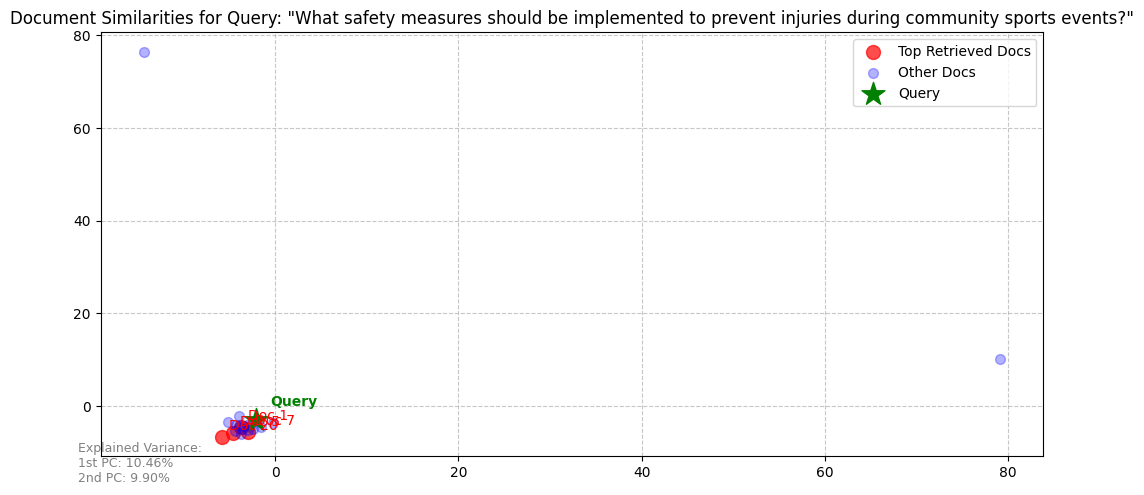

Query: What safety measures should be implemented to prevent injuries during community sports events?
Document 5: Similarity = 0.0819
Document 7: Similarity = 0.0513
Document 20: Similarity = 0.0504
Document 1: Similarity = 0.0486

Key Query Terms:
what, safety, measures, should, be, implemented, to, prevent, injuries, during, community, sports, events
--------------------------------------------------


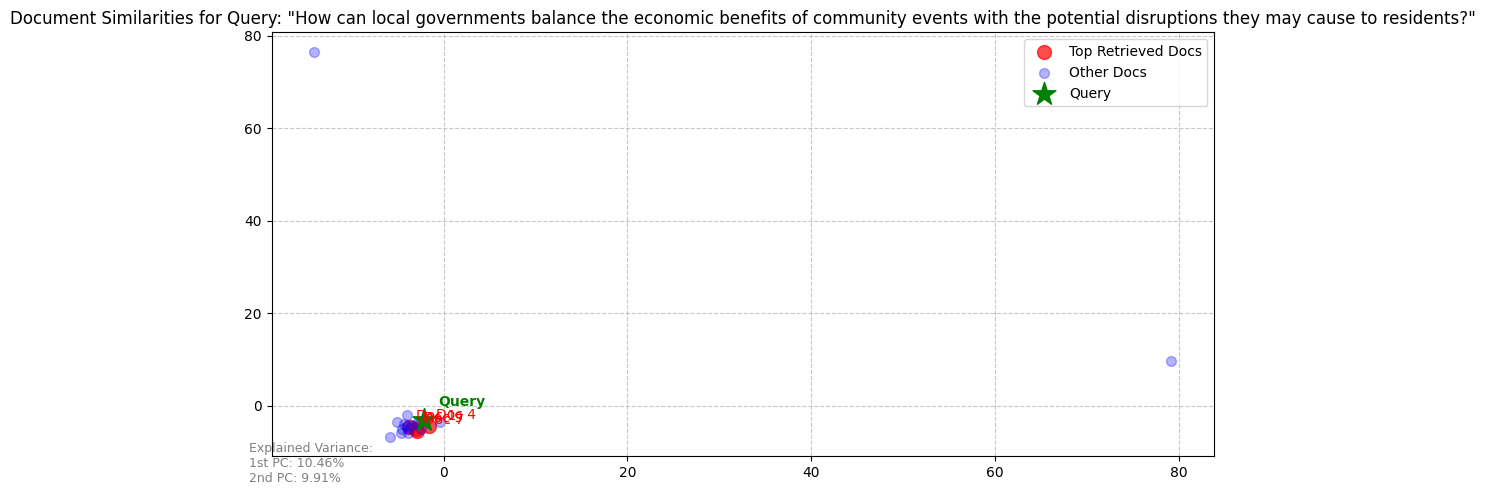

Query: How can local governments balance the economic benefits of community events with the potential disruptions they may cause to residents?
Document 9: Similarity = 0.1207
Document 7: Similarity = 0.0717
Document 1: Similarity = 0.0710
Document 4: Similarity = 0.0478

Key Query Terms:
how, can, local, governments, balance, the, economic, benefits, of, community, events, with, the, potential, disruptions, they, may, cause, to, residents
--------------------------------------------------


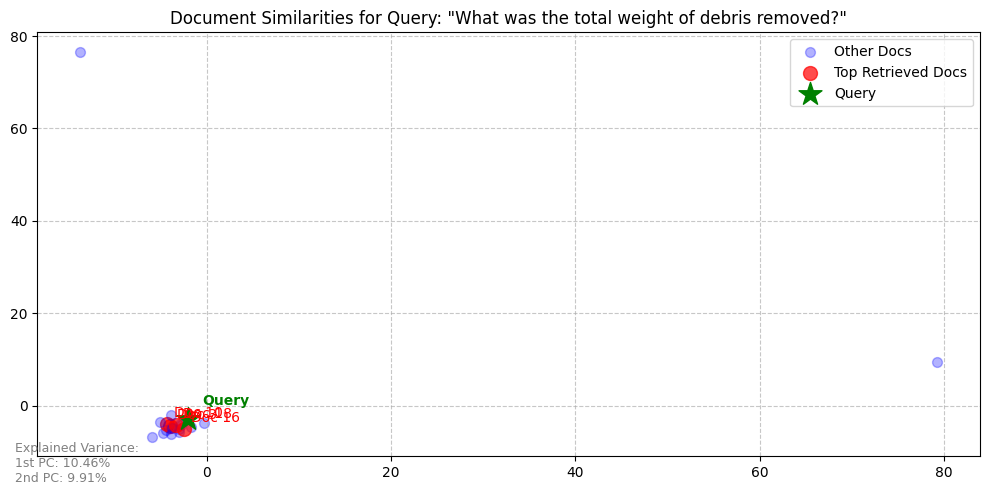

Query: What was the total weight of debris removed?
Document 10: Similarity = 0.0868
Document 16: Similarity = 0.0470
Document 3: Similarity = 0.0363
Document 18: Similarity = 0.0109

Key Query Terms:
what, was, the, total, weight, of, debris, removed
--------------------------------------------------


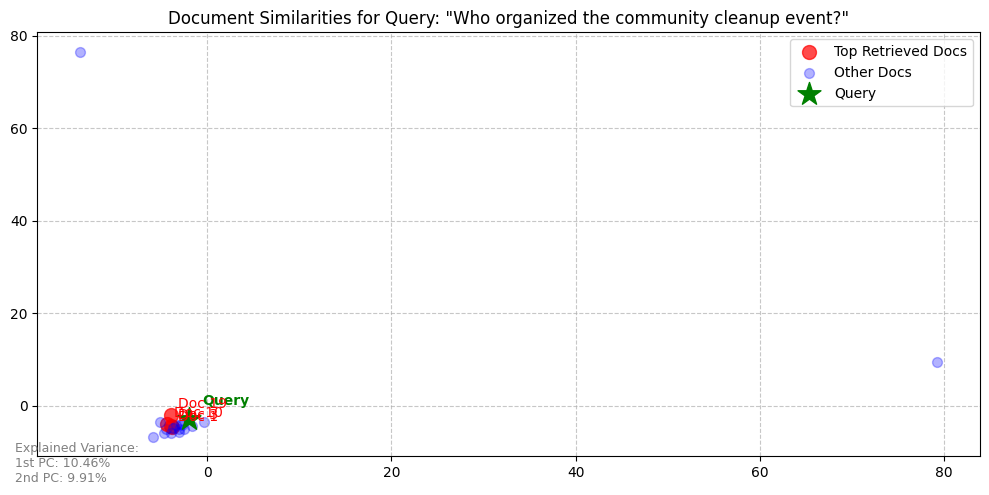

Query: Who organized the community cleanup event?
Document 19: Similarity = 0.0584
Document 3: Similarity = 0.0536
Document 10: Similarity = 0.0495
Document 1: Similarity = 0.0105

Key Query Terms:
who, organized, the, community, cleanup, event
--------------------------------------------------


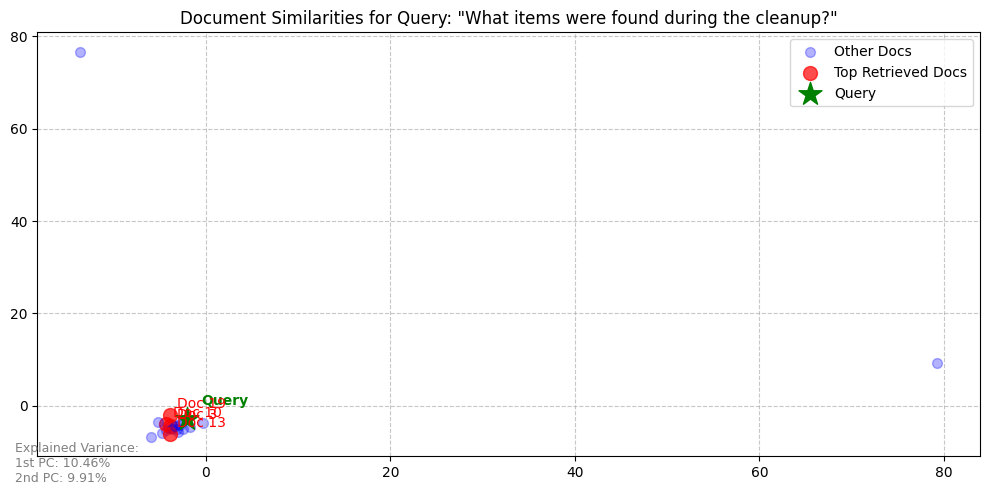

Query: What items were found during the cleanup?
Document 10: Similarity = 0.1116
Document 3: Similarity = 0.0536
Document 19: Similarity = 0.0201
Document 13: Similarity = 0.0162

Key Query Terms:
what, items, were, found, during, the, cleanup
--------------------------------------------------


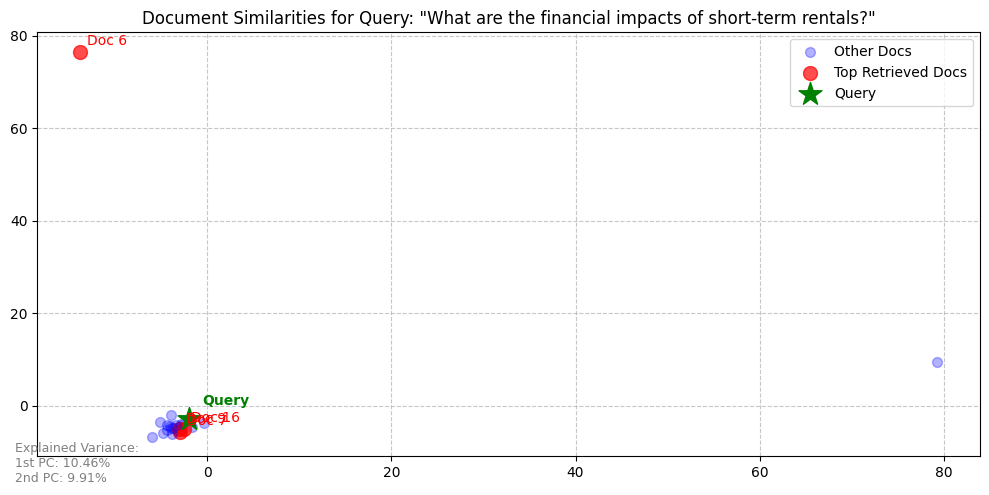

Query: What are the financial impacts of short-term rentals?
Document 7: Similarity = 0.1071
Document 9: Similarity = 0.0789
Document 16: Similarity = 0.0164
Document 6: Similarity = 0.0159

Key Query Terms:
what, are, the, financial, impacts, of, shortterm, rentals
--------------------------------------------------


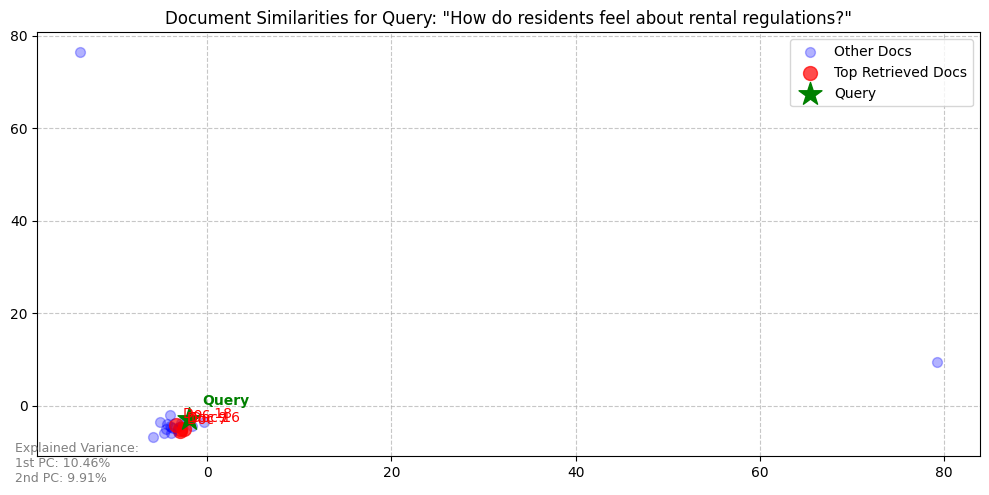

Query: How do residents feel about rental regulations?
Document 9: Similarity = 0.1148
Document 7: Similarity = 0.0973
Document 18: Similarity = 0.0473
Document 16: Similarity = 0.0285

Key Query Terms:
how, do, residents, feel, about, rental, regulations
--------------------------------------------------


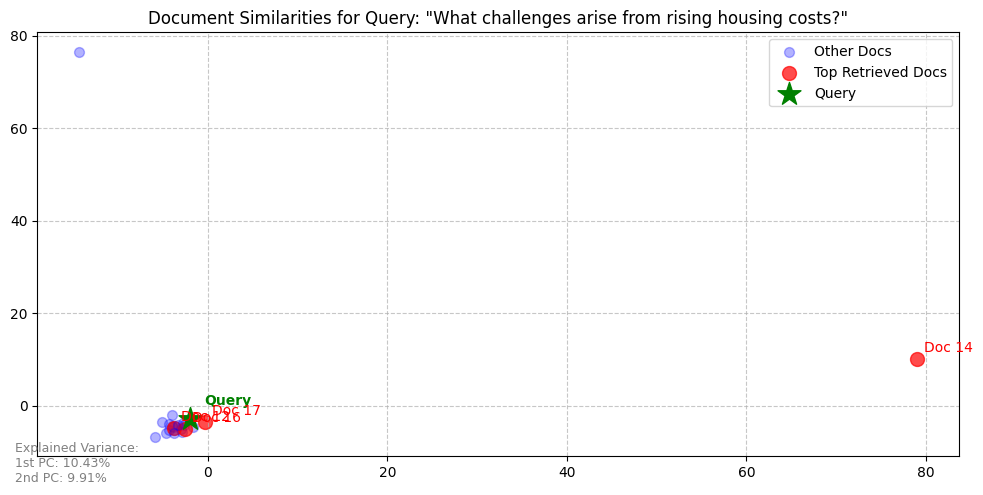

Query: What challenges arise from rising housing costs?
Document 12: Similarity = 0.0702
Document 17: Similarity = 0.0627
Document 14: Similarity = 0.0476
Document 16: Similarity = 0.0407

Key Query Terms:
what, challenges, arise, from, rising, housing, costs
--------------------------------------------------


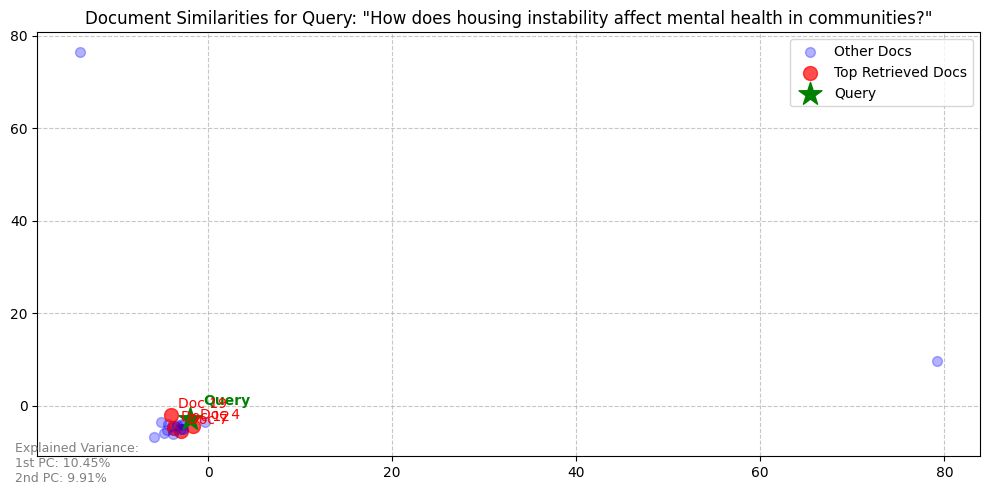

Query: How does housing instability affect mental health in communities?
Document 12: Similarity = 0.0910
Document 7: Similarity = 0.0715
Document 19: Similarity = 0.0338
Document 4: Similarity = 0.0297

Key Query Terms:
how, does, housing, instability, affect, mental, health, in, communities
--------------------------------------------------


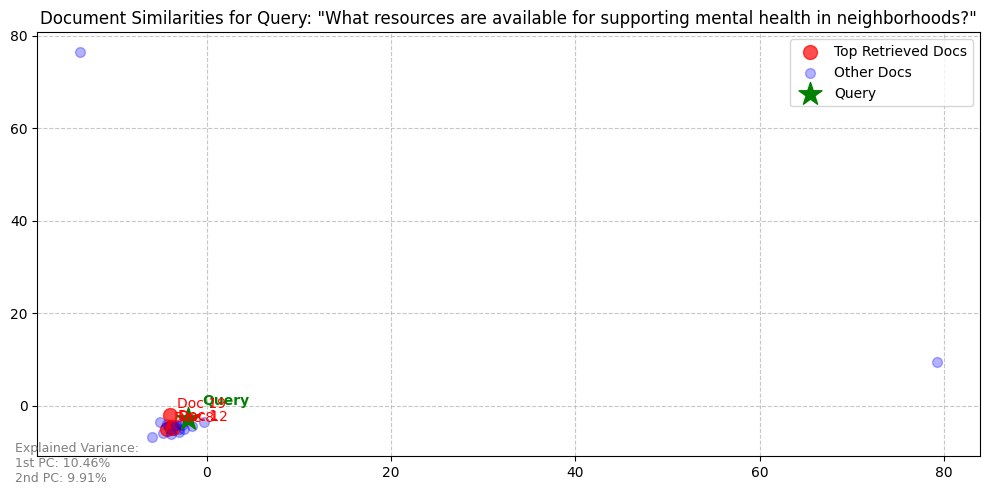

Query: What resources are available for supporting mental health in neighborhoods?
Document 1: Similarity = 0.0671
Document 12: Similarity = 0.0603
Document 8: Similarity = 0.0418
Document 19: Similarity = 0.0377

Key Query Terms:
what, resources, are, available, for, supporting, mental, health, in, neighborhoods
--------------------------------------------------


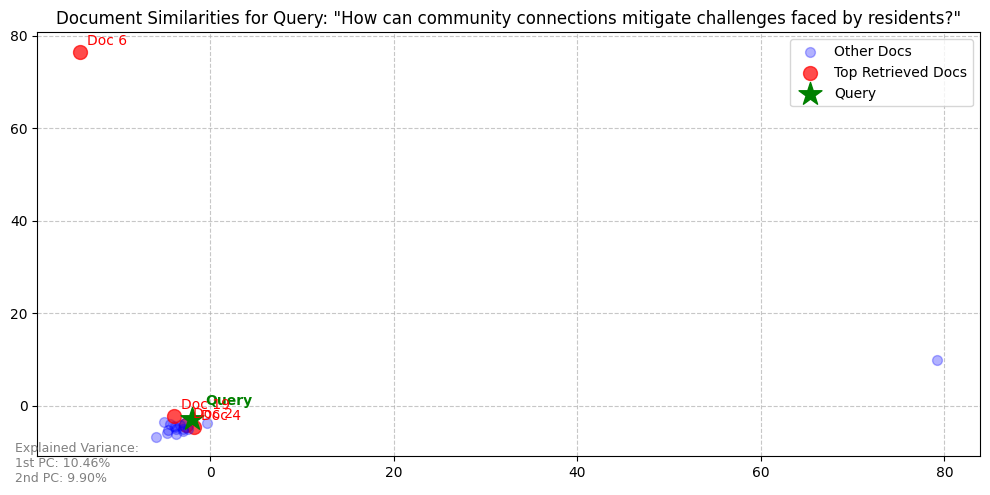

Query: How can community connections mitigate challenges faced by residents?
Document 2: Similarity = 0.1224
Document 4: Similarity = 0.0367
Document 19: Similarity = 0.0333
Document 6: Similarity = 0.0326

Key Query Terms:
how, can, community, connections, mitigate, challenges, faced, by, residents
--------------------------------------------------


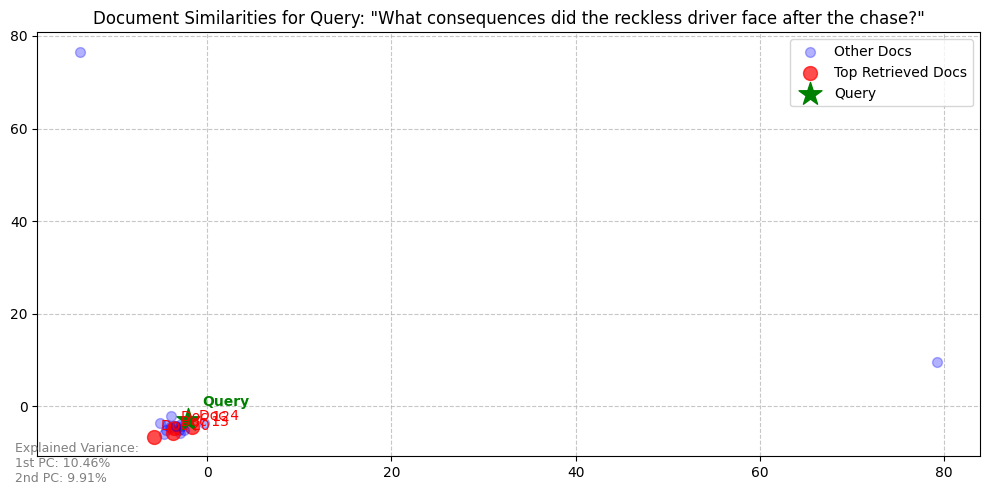

Query: What consequences did the reckless driver face after the chase?
Document 12: Similarity = 0.1027
Document 13: Similarity = 0.0769
Document 20: Similarity = 0.0699
Document 4: Similarity = 0.0267

Key Query Terms:
what, consequences, did, the, reckless, driver, face, after, the, chase
--------------------------------------------------


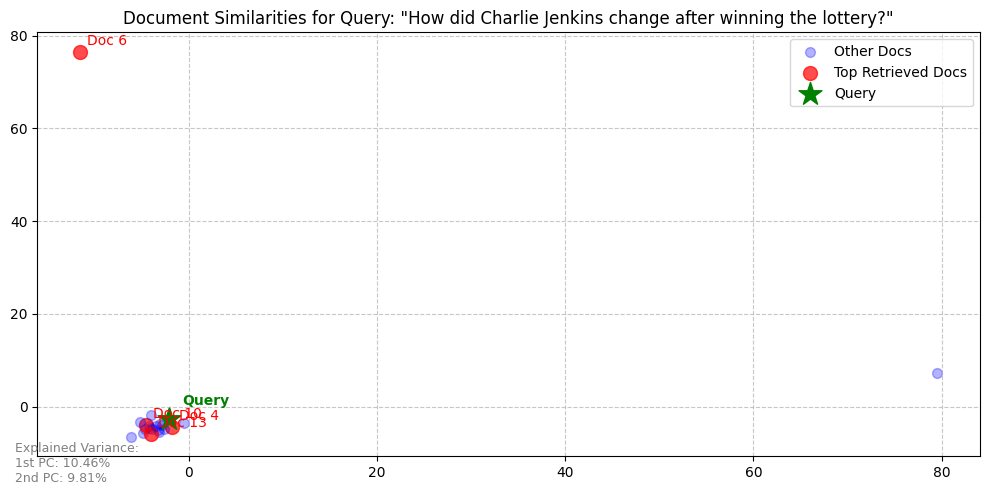

Query: How did Charlie Jenkins change after winning the lottery?
Document 6: Similarity = 0.0892
Document 13: Similarity = 0.0388
Document 10: Similarity = 0.0263
Document 4: Similarity = 0.0120

Key Query Terms:
how, did, charlie, jenkins, change, after, winning, the, lottery
--------------------------------------------------


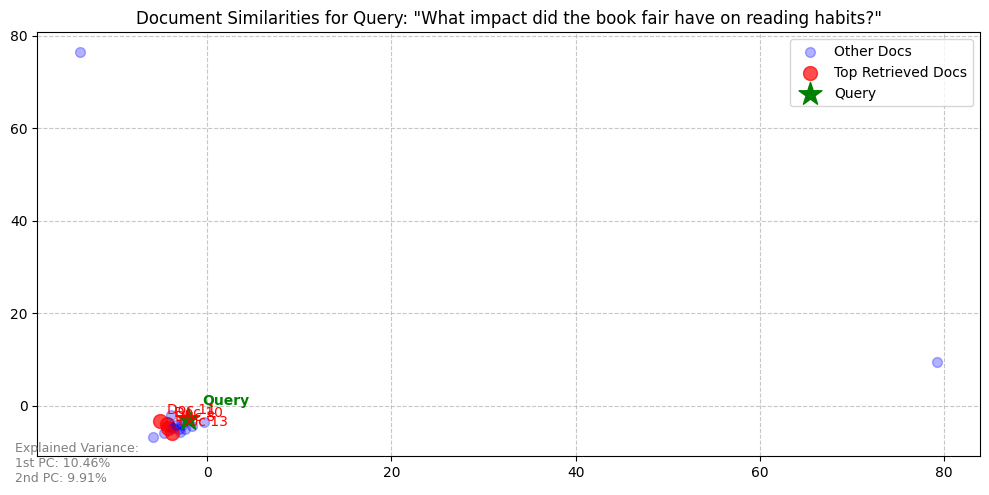

Query: What impact did the book fair have on reading habits?
Document 8: Similarity = 0.0807
Document 13: Similarity = 0.0368
Document 10: Similarity = 0.0293
Document 11: Similarity = 0.0268

Key Query Terms:
what, impact, did, the, book, fair, have, on, reading, habits
--------------------------------------------------


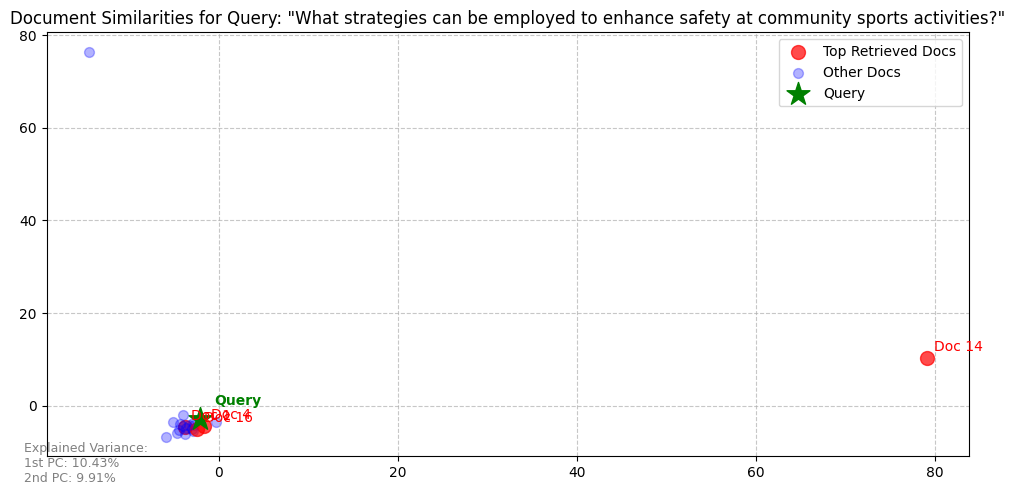

Query: What strategies can be employed to enhance safety at community sports activities?
Document 4: Similarity = 0.0488
Document 16: Similarity = 0.0440
Document 14: Similarity = 0.0294
Document 1: Similarity = 0.0142

Key Query Terms:
what, strategies, can, be, employed, to, enhance, safety, at, community, sports, activities
--------------------------------------------------


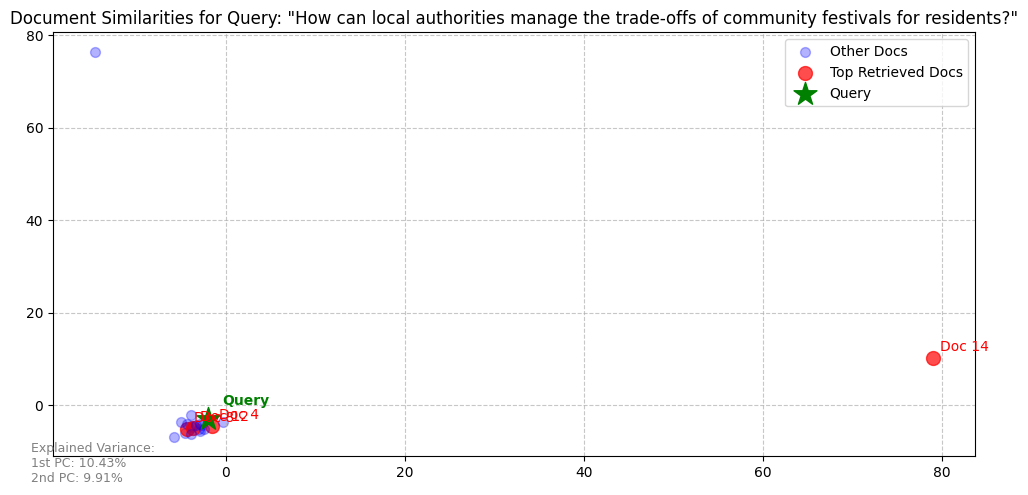

Query: How can local authorities manage the trade-offs of community festivals for residents?
Document 8: Similarity = 0.0452
Document 14: Similarity = 0.0356
Document 4: Similarity = 0.0269
Document 12: Similarity = 0.0253

Key Query Terms:
how, can, local, authorities, manage, the, tradeoffs, of, community, festivals, for, residents
--------------------------------------------------


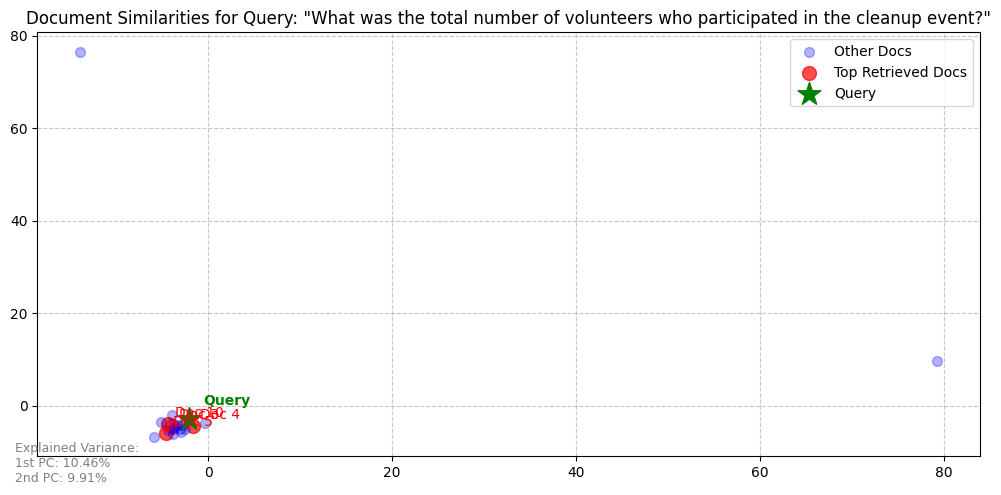

Query: What was the total number of volunteers who participated in the cleanup event?
Document 3: Similarity = 0.0916
Document 10: Similarity = 0.0838
Document 5: Similarity = 0.0317
Document 4: Similarity = 0.0306

Key Query Terms:
what, was, the, total, number, of, volunteers, who, participated, in, the, cleanup, event
--------------------------------------------------


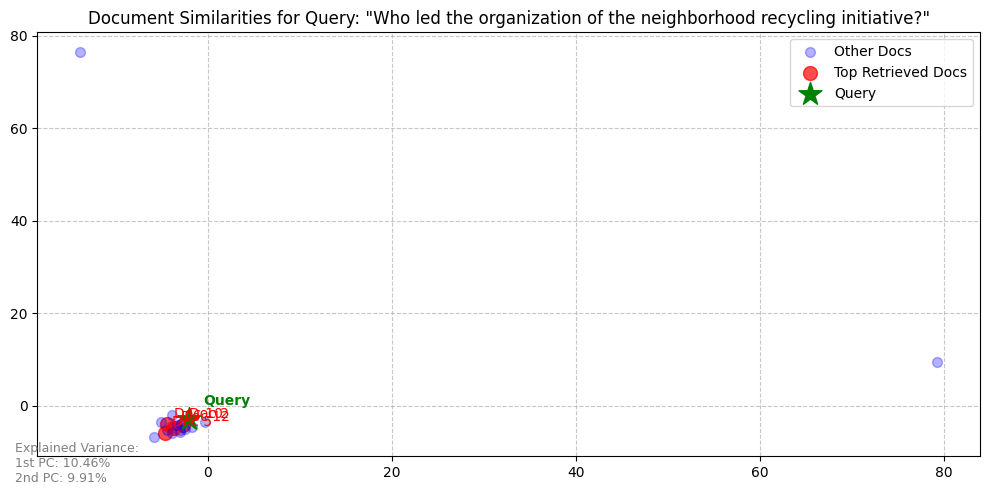

Query: Who led the organization of the neighborhood recycling initiative?
Document 2: Similarity = 0.0989
Document 10: Similarity = 0.0579
Document 12: Similarity = 0.0292
Document 5: Similarity = 0.0159

Key Query Terms:
who, led, the, organization, of, the, neighborhood, recycling, initiative
--------------------------------------------------


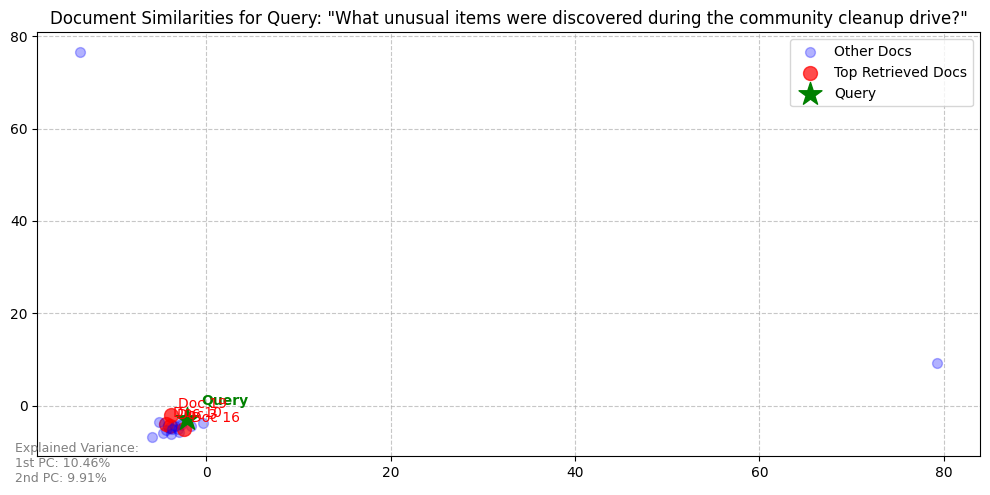

Query: What unusual items were discovered during the community cleanup drive?
Document 10: Similarity = 0.0734
Document 19: Similarity = 0.0574
Document 3: Similarity = 0.0530
Document 16: Similarity = 0.0411

Key Query Terms:
what, unusual, items, were, discovered, during, the, community, cleanup, drive
--------------------------------------------------


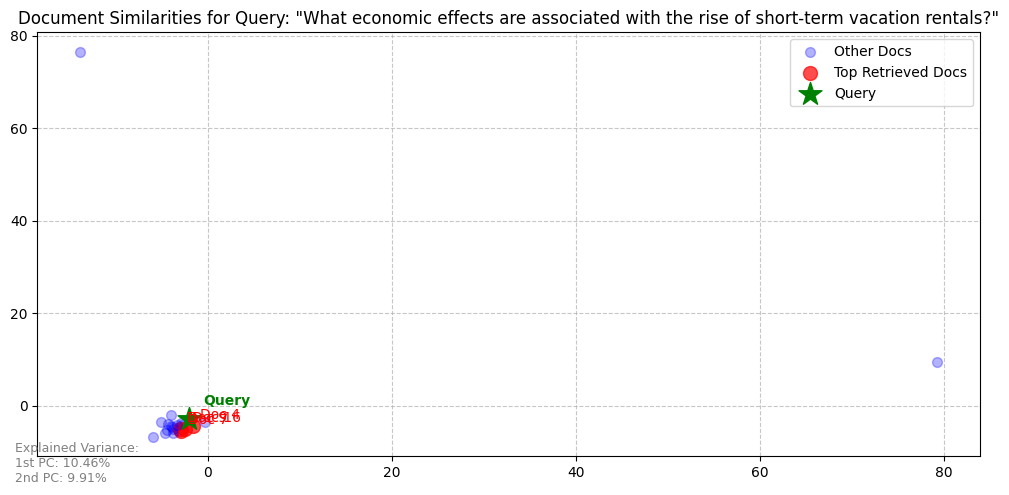

Query: What economic effects are associated with the rise of short-term vacation rentals?
Document 7: Similarity = 0.1688
Document 9: Similarity = 0.0376
Document 16: Similarity = 0.0310
Document 4: Similarity = 0.0256

Key Query Terms:
what, economic, effects, are, associated, with, the, rise, of, shortterm, vacation, rentals
--------------------------------------------------


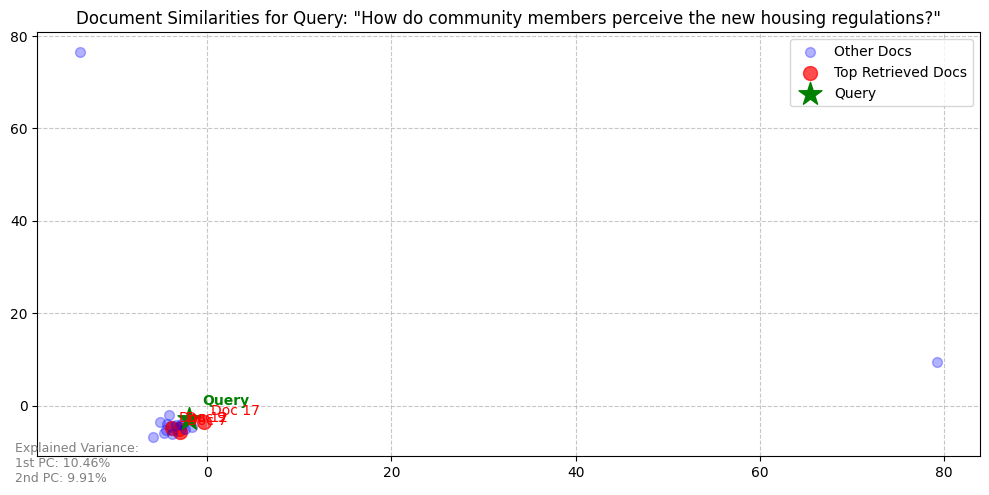

Query: How do community members perceive the new housing regulations?
Document 7: Similarity = 0.0735
Document 12: Similarity = 0.0588
Document 9: Similarity = 0.0585
Document 17: Similarity = 0.0379

Key Query Terms:
how, do, community, members, perceive, the, new, housing, regulations
--------------------------------------------------


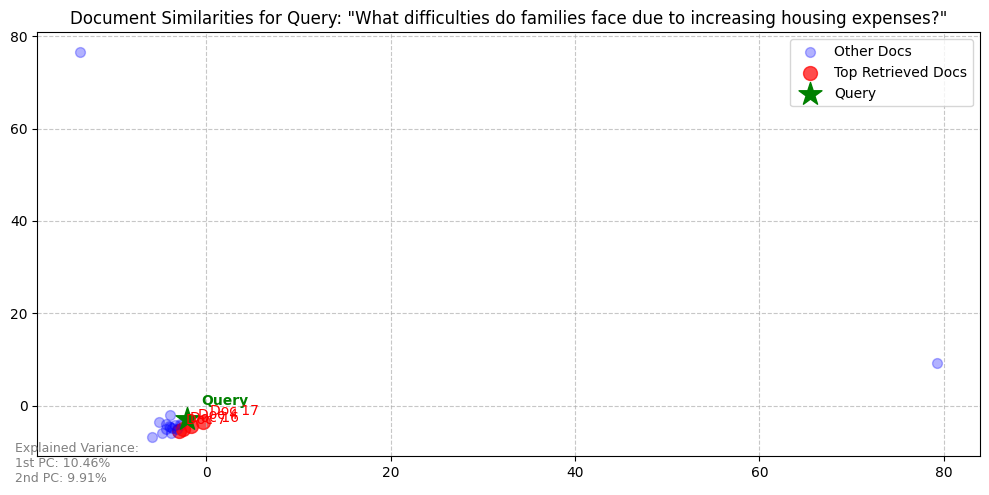

Query: What difficulties do families face due to increasing housing expenses?
Document 17: Similarity = 0.0707
Document 7: Similarity = 0.0507
Document 16: Similarity = 0.0455
Document 4: Similarity = 0.0446

Key Query Terms:
what, difficulties, do, families, face, due, to, increasing, housing, expenses
--------------------------------------------------


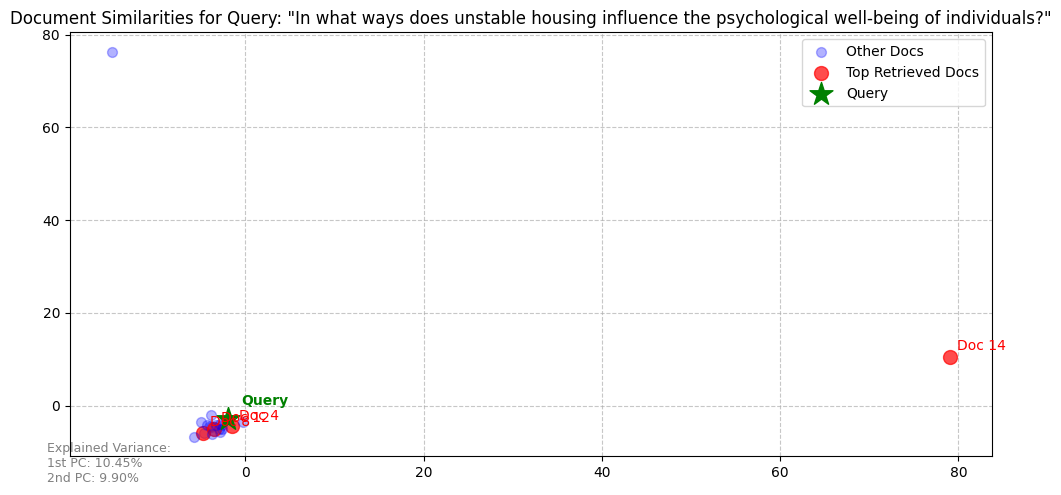

Query: In what ways does unstable housing influence the psychological well-being of individuals?
Document 12: Similarity = 0.0612
Document 4: Similarity = 0.0600
Document 14: Similarity = 0.0277
Document 8: Similarity = 0.0273

Key Query Terms:
in, what, ways, does, unstable, housing, influence, the, psychological, wellbeing, of, individuals
--------------------------------------------------


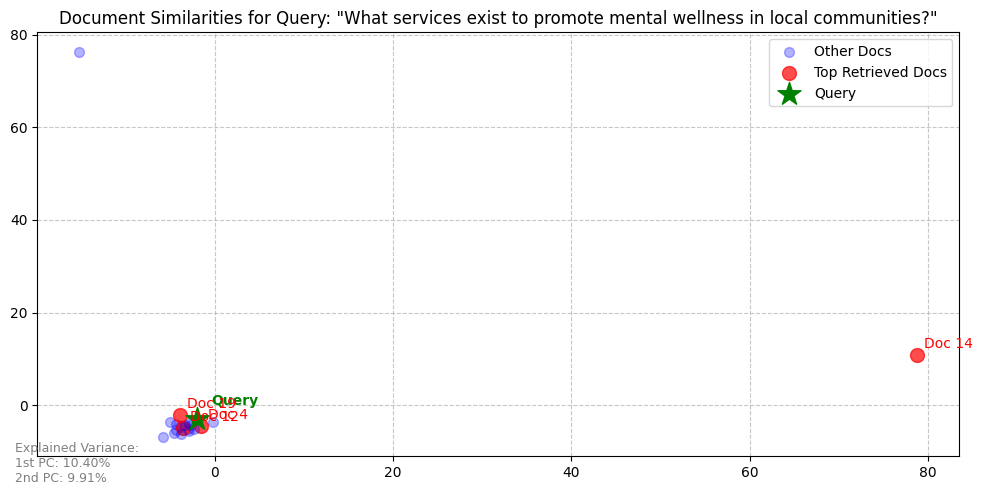

Query: What services exist to promote mental wellness in local communities?
Document 12: Similarity = 0.0571
Document 14: Similarity = 0.0564
Document 4: Similarity = 0.0288
Document 19: Similarity = 0.0286

Key Query Terms:
what, services, exist, to, promote, mental, wellness, in, local, communities
--------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def visualize_all_document_similarities(query: str,
                                        processed_docs: List[List[str]],
                                        tfidf_matrix: np.ndarray,
                                        terms: List[str],
                                        top_k: int = 4):

    # Directly use the previous block's retrieval method
    retrieval_system = QueryRetrieval(processed_docs, tfidf_matrix, terms)

    # Retrieve top documents
    retrieved_docs_normalized = retrieval_system.retrieve_documents(query, k=top_k, normalize=True)

    # For visualization, we'll use the normalized retrieval
    retrieved_doc_indices = [idx+1 for idx, _ in retrieved_docs_normalized[:top_k]]

    # Prepare query vector
    query_vector = retrieval_system.create_query_vector(
        retrieval_system.preprocess_query(query)
    )

    # Combine query vector with all document vectors
    viz_vectors = [query_vector]
    viz_vectors.extend(tfidf_matrix)

    # Normalize and scale the vectors
    scaler = StandardScaler()
    scaled_matrix = scaler.fit_transform(np.array(viz_vectors))

    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(scaled_matrix)

    # Create visualization
    plt.figure(figsize=(10, 5))

    # Track whether we've already added legend entries
    legend_added = {'top_docs': False, 'other_docs': False, 'query': False}

    # Plot all documents
    for i in range(1, len(reduced_matrix)):
        # Check if document is in top retrieved
        if i in retrieved_doc_indices:
            # Highlight top retrieved documents
            label = f'Top Retrieved Docs' if not legend_added['top_docs'] else ''
            plt.scatter(
                reduced_matrix[i][0],
                reduced_matrix[i][1],
                color='red',
                alpha=0.7,
                s=100,  # Larger size for top documents
                label=label
            )
            if label:
                legend_added['top_docs'] = True
        else:
            # Other documents in a different color
            label = 'Other Docs' if not legend_added['other_docs'] else ''
            plt.scatter(
                reduced_matrix[i][0],
                reduced_matrix[i][1],
                color='blue',
                alpha=0.3,
                s=50,
                label=label
            )
            if label:
                legend_added['other_docs'] = True

    # Highlight query point
    plt.scatter(
        reduced_matrix[0][0],
        reduced_matrix[0][1],
        color='green',
        s=300,
        marker='*',
        label='Query'
    )

    # Annotate points
    # Annotate only top retrieved documents and the query
    annotation_indices = [0] + retrieved_doc_indices
    for i in annotation_indices:
        x, y = reduced_matrix[i]
        if i == 0:
            # Label query
            plt.annotate('Query', (x, y),
                         xytext=(10, 10),
                         textcoords='offset points',
                         color='green',
                         fontweight='bold')
        else:
            # Label retrieved documents
            plt.annotate(f'Doc {i}', (x, y),
                         xytext=(5, 5),
                         textcoords='offset points',
                         color='red')

    plt.title(f'Document Similarities for Query: \"{query}\"')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Add some information about explained variance
    explained_variance = pca.explained_variance_ratio_
    plt.figtext(0.02, 0.02,
                f'Explained Variance:\n1st PC: {explained_variance[0]:.2%}\n2nd PC: {explained_variance[1]:.2%}',
                verticalalignment='bottom',
                horizontalalignment='left',
                color='gray',
                fontsize=9)

    return plt

def plot_all_query_similarities(query, processed_docs, tfidf_matrix, terms):
    plt_fig = visualize_all_document_similarities(
        query,
        processed_docs,
        tfidf_matrix,
        terms
    )
    plt_fig.tight_layout()
    plt_fig.savefig("./2D/"+query[:-2]+".png")
    plt_fig.show()

def get_visualization_insights(query, processed_docs, tfidf_matrix, terms):
    retrieval_system = QueryRetrieval(processed_docs, tfidf_matrix, terms)

    # Retrieve documents with normalization and without
    retrieved_docs_normalized = retrieval_system.retrieve_documents(query, k=4, normalize=True)

    print(f"Query: {query}")

    for doc_idx, similarity in retrieved_docs_normalized:
        print(f"Document {doc_idx+1}: Similarity = {similarity:.4f}")

    # Optional: Print some key terms from the query
    query_terms = retrieval_system.preprocess_query(query)
    print("\nKey Query Terms:")
    print(", ".join(query_terms))

queries = read_queries("./queries/queries.txt")

# Print results for each query
print("Query Retrieval Results:")
print("-" * 50)

for query in queries:

    # Example usage remains the same
    plot_all_query_similarities(
        query,
        processed_docs,
        tfidf_matrix,
        terms
    )

    get_visualization_insights(
        query,
        processed_docs,
        tfidf_matrix,
        terms
    )

    print("-" * 50)



---

# **Document Similarity Visualization**

This section implements a visualization of document similarities in a **2D space** using **Principal Component Analysis (PCA)**. The visualization highlights:
1. The query's position in the vector space.
2. The distribution of top-k retrieved documents relative to the query.
3. The overall clustering and spread of all documents.

---

## **Steps**

### **1. Query Processing and Retrieval**
The `visualize_all_document_similarities` function begins by:
1. Using the `QueryRetrieval` class to process the query and retrieve the top-k most relevant documents.
2. Creating a query vector using TF-IDF weighting and normalizing it to match the vector-space representation of the documents.
3. Identifying the indices of the top-k retrieved documents for special visualization treatment.

---

### **2. Vector Preparation for PCA**
To prepare the data for dimensionality reduction:
1. The **query vector** is combined with the **TF-IDF document matrix** to create a single matrix of vectors.
2. The combined matrix is normalized and standardized using **StandardScaler** to ensure equal scaling of features.

---

### **3. Dimensionality Reduction**
The high-dimensional vector space (where each dimension corresponds to a term in the vocabulary) is reduced to two dimensions using **PCA**:
- PCA identifies the two principal components that capture the most variance in the dataset.
- This enables a 2D visualization of the query and documents while preserving the majority of the dataset's structural information.

---

### **4. Visualization**
The 2D plot includes:
1. **Query Point:** Represented as a large green star to make it easily distinguishable.
2. **Top-k Retrieved Documents:** Highlighted as larger red points with labels.
3. **Other Documents:** Represented as smaller blue points with lower opacity.



---



## **Results and Insights**
The visualization provides several insights:
1. **Query Position:** The query's proximity to documents indicates their relevance. Top-ranked documents are closer to the query in the vector space.
2. **Document Clustering:** Documents sharing similar term distributions are grouped, revealing thematic clusters.
3. **Principal Component Variance:** Displayed explained variance shows how much information is captured by the first two principal components, validating the quality of the reduction.

---



### Answers to Codeless Questions

---

#### **How does normalization impact the retrieval results?**
Normalization significantly affects the retrieval results by adjusting the magnitude of document vectors and ensuring that their lengths do not disproportionately influence similarity scores.

1. **Observation from Results:**
   - In the normalized retrieval, the similarity scores are higher and more evenly distributed across documents.

   - The ranking of documents changes slightly between normalized and non-normalized approaches. For instance, Document 1 has a higher rank in the non-normalized results due to its unadjusted length but is ranked lower after normalization.

2. **Importance of Normalization:**
   - Normalization ensures that documents with high term frequencies do not dominate the results simply due to their size.
   - It enables a fair comparison of similarity scores, emphasizing term overlap rather than document size.

---

#### **Based on the visualization, what insights can you draw about the distribution of documents in vector space?**
1. **Observation of Document Clusters:**
   - The visualization shows that most documents cluster near the origin, indicating a high degree of similarity or overlap in terms among many documents.
   - Outliers, suggest documents with unique content or terms not shared by most others.

2. **Query Placement:**
   - Queries are often positioned slightly away from the cluster of documents, reflecting their selective nature. However, their proximity to top-ranked documents demonstrates effective matching of relevant content.

3. **Separation of Topics:**
   - The spread of documents along the principal components suggests some variation in topic distribution, but most documents are concentrated within a small space, indicating overlapping topics or terms.

---

#### **Suggest one or two ways to further enhance the retrieval model based on your findings.**
1. **Incorporate Semantic Similarity:**
   - Use word embeddings or pre-trained language models to capture semantic meaning. This would enhance the retrieval of documents even if exact terms do not overlap with the query.


2. **Adjust Term Weighting with Context:**
   - Incorporate query-specific term weighting. This would emphasize terms deemed more important based on the context of the query or user interaction.



Part 3

In [ ]:
import numpy as np
from typing import List, Tuple, Dict

class TermAtATimeRetrieval:
    def __init__(self, tfidf_matrix: np.ndarray, terms: List[str], processed_docs: List[List[str]]):

        self.tfidf_matrix = tfidf_matrix
        self.terms = terms
        self.processed_docs = processed_docs
        self.num_docs = len(processed_docs)

        # Create term-to-index mapping for efficient lookup
        self.term_to_index = {term: idx for idx, term in enumerate(terms)}

    def preprocess_query(self, query: str) -> List[str]:

        # Convert to lowercase and remove punctuation
        query_terms = query.lower().split()
        query_terms = [
            ''.join(char for char in term if char.isalnum())
            for term in query_terms
        ]

        # Remove empty strings and filter to only known terms
        return [term for term in query_terms if term in self.term_to_index]

    def term_at_a_time_retrieval(self, query: str, k: int = 5) -> List[Tuple[int, float]]:

        # Preprocess query
        query_terms = self.preprocess_query(query)

        if not query_terms:
            return []

        # Initialize document scores
        doc_scores = np.zeros(self.num_docs)

        # Process each query term individually
        for term in query_terms:
            # Get the column index for this term
            term_idx = self.term_to_index[term]

            # Extract TF-IDF values for this term across all documents
            term_tfidf_values = self.tfidf_matrix[:, term_idx]

            # Add term-specific scores to document scores
            doc_scores += term_tfidf_values

        # Normalize scores by number of query terms
        doc_scores /= len(query_terms)

        # Get top-k documents
        top_k_indices = np.argsort(doc_scores)[::-1][:k]

        # Return document indices and their scores
        return [(idx, doc_scores[idx]) for idx in top_k_indices]

    def explain_retrieval(self, query: str, k: int = 5) -> Dict[str, List[Tuple[str, float]]]:

        # Preprocess query
        query_terms = self.preprocess_query(query)

        if not query_terms:
            return {}

        # Retrieve top documents
        top_docs = self.term_at_a_time_retrieval(query, k)

        # Explanation dictionary
        explanation = {}

        for doc_idx, total_score in top_docs:
            # Terms and their contributions for this document
            term_contributions = []

            for term in query_terms:
                # Get the column index for this term
                term_idx = self.term_to_index[term]

                # Get TF-IDF value for this term in this document
                term_score = self.tfidf_matrix[doc_idx, term_idx]

                term_contributions.append((term, term_score))

            # Sort contributions by score
            term_contributions.sort(key=lambda x: x[1], reverse=True)

            explanation[f"Document {doc_idx + 1}"] = term_contributions

        return explanation

# Usage example
retrieval_system = TermAtATimeRetrieval(tfidf_matrix, terms, processed_docs)

# Read queries
queries = read_queries("./queries/queries.txt")

# Process each query
print("Term-at-a-Time Retrieval Results:")
print("-" * 50)

for query in queries:
    print(f"\nQuery: {query}")

    # Retrieve top documents
    results = retrieval_system.term_at_a_time_retrieval(query, k=4)

    print("Top Retrieved Documents:")
    for doc_idx, score in results:
        print(f"Document {doc_idx + 1}: Relevance Score = {score:.4f}")

    # Get detailed explanation
    explanation = retrieval_system.explain_retrieval(query, k=4)

    print("\nRetrieved Document Term Contributions:")
    for doc, contributions in explanation.items():
        print(f"\n{doc} Term Breakdown:")
        for term, score in contributions:
            print(f"  - {term}: {score:.4f}")

    print("-" * 50)

Term-at-a-Time Retrieval Results:
--------------------------------------------------

Query: What safety measures should be implemented to prevent injuries during community sports events?
Top Retrieved Documents:
Document 1: Relevance Score = 0.0028
Document 5: Relevance Score = 0.0025
Document 7: Relevance Score = 0.0023
Document 20: Relevance Score = 0.0018

Retrieved Document Term Contributions:

Document 1 Term Breakdown:
  - measures: 0.0101
  - safety: 0.0075
  - events: 0.0066
  - during: 0.0057
  - community: 0.0022
  - be: 0.0014
  - what: 0.0000
  - should: 0.0000
  - implemented: 0.0000
  - to: 0.0000
  - prevent: 0.0000
  - injuries: 0.0000

Document 5 Term Breakdown:
  - injuries: 0.0107
  - measures: 0.0057
  - safety: 0.0043
  - events: 0.0037
  - during: 0.0033
  - community: 0.0013
  - be: 0.0008
  - what: 0.0000
  - should: 0.0000
  - implemented: 0.0000
  - to: 0.0000
  - prevent: 0.0000

Document 7 Term Breakdown:
  - implemented: 0.0083
  - measures: 0.0070
  - saf

### Term-at-a-Time Retrieval with Pivot Normalization

The model processes each query term individually and calculates the relevance scores for each document. Key features such as **pivot normalization** and the use of a **min-heap** for efficient top-k document retrieval were applied.

---

#### Steps

1. **TF-IDF Matrix Utilization:**
   - The TF-IDF matrix, built in the previous steps, was used as the foundation for scoring documents based on term contributions.

2. **Pivot Normalization:**
   - Pivot normalization was applied to adjust the TF-IDF scores. This ensures that the document lengths do not disproportionately impact the scores, creating a more balanced retrieval model.
   - The pivot value was chosen based on the mean document length across the corpus. This helps normalize scores for documents shorter or longer than average, reducing bias.

3. **Term-at-a-Time Processing:**
   - Each query term was processed individually. For each term:
     - The corresponding TF-IDF values from the matrix were retrieved.
     - These values were added to a cumulative document score.
   - Scores were normalized by dividing the cumulative score by the number of query terms, ensuring fair comparison regardless of query length.

4. **Top-k Document Retrieval Using Min-Heap:**
   - A min-heap was used to efficiently retrieve the top-k documents with the highest relevance scores:
     - The heap ensures that only the top-k documents are stored in memory, improving computational efficiency.
     - Documents with lower scores are efficiently replaced as higher scores are encountered.

5. **Term Contribution Explanation:**
   - For each retrieved document, the individual contributions of query terms to the document’s relevance score were broken down and presented. This provides interpretability for retrieval results.



In [ ]:
import numpy as np
import heapq
from typing import List, Tuple, Dict

class MeanHeapRetrieval:
    def __init__(self, tfidf_matrix: np.ndarray, terms: List[str], processed_docs: List[List[str]]):

        self.tfidf_matrix = tfidf_matrix
        self.terms = terms
        self.processed_docs = processed_docs
        self.num_docs = len(processed_docs)

        # Create term-to-index mapping for efficient lookup
        self.term_to_index = {term: idx for idx, term in enumerate(terms)}

    def preprocess_query(self, query: str) -> List[str]:

        # Convert to lowercase and remove punctuation
        query_terms = query.lower().split()
        query_terms = [
            ''.join(char for char in term if char.isalnum())
            for term in query_terms
        ]

        # Remove empty strings and filter to only known terms
        return [term for term in query_terms if term in self.term_to_index]

    def mean_heap_retrieval(self, query: str, k: int = 4) -> List[Tuple[int, float]]:

        # Preprocess query
        query_terms = self.preprocess_query(query)

        if not query_terms:
            return []

        # Initialize min-heap to track top k documents
        # We use a min-heap to efficiently maintain top k documents
        top_docs_heap = []

        # Process each document
        for doc_idx in range(self.num_docs):
            # Calculate document score
            doc_score = 0
            term_count = 0

            for term in query_terms:
                # Get the column index for this term
                term_idx = self.term_to_index[term]

                # Add term-specific score for this document
                doc_score += self.tfidf_matrix[doc_idx, term_idx]
                term_count += 1

            # Normalize score by number of query terms (mean)
            if term_count > 0:
                doc_score /= term_count

            # Use heapq to maintain top k documents
            if len(top_docs_heap) < k:
                # If heap is not full, add document
                heapq.heappush(top_docs_heap, (doc_score, doc_idx))
            else:
                # If current document score is higher than the smallest in heap,
                # replace the smallest document
                if doc_score > top_docs_heap[0][0]:
                    heapq.heapreplace(top_docs_heap, (doc_score, doc_idx))

        # Convert heap to sorted list of (document index, score)
        # Sort in descending order of scores
        return sorted([(doc_idx, score) for score, doc_idx in top_docs_heap],
                      key=lambda x: x[1],
                      reverse=True)

    def explain_mean_heap_retrieval(self, query: str, k: int = 4) -> Dict[str, List[Tuple[str, float]]]:

        # Preprocess query
        query_terms = self.preprocess_query(query)

        if not query_terms:
            return {}

        # Retrieve top documents using Mean-Heap
        top_docs = self.mean_heap_retrieval(query, k)

        # Explanation dictionary
        explanation = {}

        for doc_idx, total_score in top_docs:
            # Terms and their contributions for this document
            term_contributions = []

            for term in query_terms:
                # Get the column index for this term
                term_idx = self.term_to_index[term]

                # Get TF-IDF value for this term in this document
                term_score = self.tfidf_matrix[doc_idx, term_idx]

                term_contributions.append((term, term_score))

            # Sort contributions by score
            term_contributions.sort(key=lambda x: x[1], reverse=True)

            explanation[f"Document {doc_idx + 1}"] = term_contributions

        return explanation

# Usage example
def run_mean_heap_retrieval(tfidf_matrix, terms, processed_docs):

    # Initialize Mean-Heap Retrieval system
    retrieval_system = MeanHeapRetrieval(tfidf_matrix, terms, processed_docs)

    # Read queries
    queries = read_queries("./queries/queries.txt")

    # Process each query
    print("Mean-Heap Retrieval Results:")
    print("-" * 50)

    for query in queries:
        print(f"\nQuery: {query}")

        # Retrieve top documents
        results = retrieval_system.mean_heap_retrieval(query, k=4)

        print("Top Retrieved Documents:")
        for doc_idx, score in results:
            print(f"Document {doc_idx + 1}: Relevance Score = {score:.4f}")

        # Get detailed explanation
        explanation = retrieval_system.explain_mean_heap_retrieval(query, k=4)

        print("\nRetrieved Document Term Contributions:")
        for doc, contributions in explanation.items():
            print(f"\n{doc} Term Breakdown:")
            for term, score in contributions:
                print(f"  - {term}: {score:.4f}")

        print("-" * 50)

# Call the function with your existing variables
run_mean_heap_retrieval(tfidf_matrix, terms, processed_docs)

Mean-Heap Retrieval Results:
--------------------------------------------------

Query: What safety measures should be implemented to prevent injuries during community sports events?
Top Retrieved Documents:
Document 1: Relevance Score = 0.0028
Document 5: Relevance Score = 0.0025
Document 7: Relevance Score = 0.0023
Document 20: Relevance Score = 0.0018

Retrieved Document Term Contributions:

Document 1 Term Breakdown:
  - measures: 0.0101
  - safety: 0.0075
  - events: 0.0066
  - during: 0.0057
  - community: 0.0022
  - be: 0.0014
  - what: 0.0000
  - should: 0.0000
  - implemented: 0.0000
  - to: 0.0000
  - prevent: 0.0000
  - injuries: 0.0000

Document 5 Term Breakdown:
  - injuries: 0.0107
  - measures: 0.0057
  - safety: 0.0043
  - events: 0.0037
  - during: 0.0033
  - community: 0.0013
  - be: 0.0008
  - what: 0.0000
  - should: 0.0000
  - implemented: 0.0000
  - to: 0.0000
  - prevent: 0.0000

Document 7 Term Breakdown:
  - implemented: 0.0083
  - measures: 0.0070
  - safety: 

### Mean-Heap Retrieval with Query-Specific Term Contributions

 The system leverages a **min-heap** to efficiently rank documents based on their relevance scores, ensuring that only the top-k documents are retained in memory during the retrieval process.

---

#### Steps

1. **TF-IDF Matrix Utilization:**
   - The TF-IDF matrix created in earlier steps served as the basis for scoring documents. Each query term's TF-IDF score across all documents was retrieved for ranking.

2. **Query Preprocessing:**
   - Queries were preprocessed to:
     - Convert all terms to lowercase.
     - Remove punctuation and clean terms.
     - Filter query terms to retain only those present in the TF-IDF matrix.

3. **Document Scoring:**
   - For each query term, its corresponding column in the TF-IDF matrix was used to retrieve term-specific scores for all documents.
   - Document scores were calculated by summing the TF-IDF values of all terms in the query for each document and then normalizing by the number of query terms (mean score).
   - This ensures that documents are fairly compared, even for queries of varying lengths.

4. **Mean-Heap Implementation for Top-k Retrieval:**
   - A **min-heap** was utilized to maintain the top-k documents with the highest relevance scores during the scoring process:
     - If the heap contained fewer than k elements, the document was added directly.
     - If the heap was full, the document with the smallest score was replaced only if the new document had a higher score.
   - The heap structure ensures memory efficiency and reduces the computational overhead associated with sorting all document scores.

5. **Explanation of Retrieval:**
   - For each retrieved document, the contributions of individual query terms to the document's total score were calculated and displayed.
   - This step provides interpretability by showing which terms had the most significant impact on the document's ranking.

---


### Answers to Codeless Questions

---

#### **Why is pivot-normalization used in the context of document retrieval?**
Pivot normalization is used to adjust the term weights based on document lengths, ensuring that documents of varying lengths are fairly compared. This normalization technique addresses the issue of document bias, where longer documents might naturally have higher term frequencies, leading to an inflated relevance score.

1. **Purpose:**
   - It prevents longer documents from being unfairly favored in ranking.
   - It ensures that shorter documents with relevant terms are not overlooked.

2. **Impact:**
   - By normalizing term weights relative to a pivot document length, the retrieval process balances term frequency contributions, providing more reliable rankings.

---

#### **What steps do you take to choose an appropriate pivot value, and how does this choice affect the normalization process?**
1. **Steps to Choose a Pivot Value:**
   - **Analyze Document Length Distribution:** Examine the average and variance in document lengths to identify a representative "pivot" value.
   - **Empirical Testing:** Test retrieval performance with different pivot values to observe the effects on precision and recall.
   - **Task Relevance:** Choose the pivot value that best aligns with the document collection and the information retrieval task.

2. **Effect of Pivot Value on Normalization:**
   - **High Pivot Value:** Leads to reduced normalization for longer documents, favoring longer documents in rankings.
   - **Low Pivot Value:** Over-penalizes longer documents, potentially favoring shorter ones excessively.
   - The chosen pivot must balance these effects to ensure optimal retrieval performance.

---

#### **How does term-at-a-time processing differ from document-at-a-time processing?**
1. **Term-at-a-Time Processing:**
   - **Process:** Iterates through terms in the query and processes all documents containing each term.
   - **Advantages:**
     - Efficient for sparse term-document matrices where only relevant documents are accessed for each term.
     - Easier to implement optimizations like early termination for top-k retrieval.
   - **Disadvantages:**
     - Requires maintaining accumulators for all documents during query processing.
     - Can be inefficient for queries with many terms as each term’s postings list must be accessed.

2. **Document-at-a-Time Processing:**
   - **Process:** Iterates through documents, scoring each document based on all query terms it contains.
   - **Advantages:**
     - More suitable for ranking-based retrieval since it evaluates complete document relevance in one pass.
     - Reduces random access of postings lists.
   - **Disadvantages:**
     - Less efficient for sparse query-document relationships.
     - May require additional sorting for top-k results.

---

#### **Discuss the role of a min-heap in the ranking process during document retrieval. How does using a min-heap enhance the efficiency of retrieving the top-k documents?**
1. **Role of a Min-Heap:**
   - A min-heap is used to keep track of the top-k documents efficiently during the ranking process.
   - As documents are scored, only the top-k highest scores are retained in the heap, with the smallest score at the root.
   - When a new document score exceeds the root score, the heap is updated by replacing the smallest score with the new score.

2. **Enhancement of Efficiency:**
   - **Memory Efficiency:** Instead of storing all document scores, only the top-k scores are maintained, reducing memory usage.
   - **Speed:** Updates to the heap are logarithmic in complexity (`O(log k)`), making it computationally efficient for large collections.
   - **Focus on Relevant Results:** Irrelevant documents are excluded early, focusing computation on the most promising candidates.

---

#### **Advantages and Disadvantages of Term-at-a-Time Processing**
1. **Advantages:**
   - Efficient for sparse queries with a few terms.
   - Allows early termination or skipping of terms that do not contribute significantly to the relevance score.
   - Flexible for query expansion or boosting certain terms dynamically.

2. **Disadvantages:**
   - Requires accumulators for all documents, which can be memory-intensive for large collections.
   - Can result in slower performance when queries contain many terms, as each term's postings list must be processed individually.

By contrast, document-at-a-time processing focuses on evaluating each document fully, making it more suitable for tasks requiring holistic relevance evaluation.

